## Imports

In [77]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax

import shapely.geometry as geom
import shapely.affinity as aff

import math

import collections.abc

# Global Functions

## Plotting geometries

In [78]:
def plotCoords(coords):
    x,y = zip(*list(coords))
    ax.plot(x,y)

def plotPoints(points):
    x,y = zip(*list(points))
    ax.scatter(x, y)

def plotPolys(polys):
    for poly in polys:
        if not getattr(poly, "exterior", None):
            print("got line?")

        plotCoords(poly.exterior.coords)

        for hole in poly.interiors:
            plotCoords(hole.coords)

## Generating a regular polygon

In [79]:
def makePoly(sides, radius):
    line = geom.LineString([(0, 0), (0, radius)])
    vertices = []

    if sides % 2 == 0:
        line = aff.rotate(line, -360 / sides)

    for i in range(0, sides):
        line = geom.LineString(recursiveRound([*line.coords], 4))
        vertices.append(line.coords[1])
        line = aff.rotate(line, -360 / sides, origin=(0, 0))
    return geom.Polygon(vertices)

## Recursively rounding every number in an iterable

In [80]:
def recursiveRound(iter, digits):
    if isinstance(iter, collections.abc.Iterable) == False:
        try: # if it is a number, round it
            return round(iter, digits)
        except:
            return iter
    else: # assign child objects (iter) to current object
        for index, value in enumerate(iter):
            recursed = recursiveRound(value, digits)
            try: # when iter isn't a tuple
                iter[index] = recursed
            except(TypeError):
                iterCopy = list(iter)
                iterCopy[index] = recursed
                iter = tuple(iterCopy)
        return iter

# print(recursiveRound([(0.292, 0.21722014), [(118.2194, 0.10282)]], 2))

## Finding the angle between three points

In [97]:
def angleFinder(x, y, z):
    """
    a^2 = b^2 + c^2 − 2bccos(A)
    """
    a = math.sqrt((list(*y.coords)[1] - list(*z.coords)[1])**2 + (list(*y.coords)[0] - list(*z.coords)[0])**2)
    b = x.distance(z)
    c = x.distance(y)

    return math.acos((b**2 + c**2 - a**2)/(2*b*c))

# angleFinder(geom.Point(0, 3), geom.Point(1, 2), geom.Point(3, -1))

0.1418970546041636

# Testing

In [98]:
a = makePoly(3, 3)
b = makePoly(4, 3.5)

b = aff.translate(b, yoff=abs(a.bounds[3]) + abs(b.bounds[1]))

In [99]:
rotationPoint = geom.Point((0, a.bounds[3]))

indexA = len(a.exterior.coords) // 2 - 1
nextA = geom.Point(a.exterior.coords[indexA])

indexB = len(b.exterior.coords) // 2 - 1
nextB = geom.Point(b.exterior.coords[indexB])

In [103]:
print(*rotationPoint.coords)
print(rotationPoint.coords)

(1.75, 3.0)


In [100]:
for i in range(1, 6):
    b = aff.rotate(b, -angleFinder(rotationPoint, nextB, nextA), origin=rotationPoint, use_radians="true")
    if geom.LineString(b.exterior.coords).contains(nextA):
        # if b is over the edge of a
        rotationPoint = nextA
        nextA = a.exterior.coords[(indexA + 1) % len(a.exterior.coords)]
        nextB = a.exterior.coords[indexB]
    else:
        rotationPoint = nextB
        # nextA doesn't change
        nextB = b.exterior.coords[(indexB - 1) % len(b.exterior.coords)]

AttributeError: 'tuple' object has no attribute 'coords'

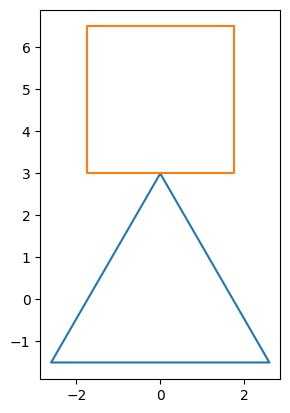

In [ ]:
fig, ax = plt.subplots(1, 1)
plotPolys([a, b])
ax.axes.set_aspect("equal")

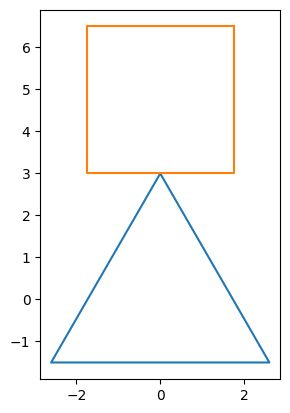